In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### dataset information

In [5]:
from datetime import datetime
dataset = 'fmnist'
dims = (28,28,1)
umap_prop = 0.0
num_classes = 10
PROJECTION_DIMS = 128
labels_per_class = 'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
print(datestring)

2020_07_29_13_04_55_376196


### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_FMNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_labeled = Y_train
    Y_masked = np.ones(len(Y_train))
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build umap graph

In [10]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [11]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [12]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [13]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [14]:
# make sure batch size is no bigger than the number of labels per class
labeled_batch_size = batch_size if batch_size < len(Y_labeled) else len(Y_labeled)
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)
print(labeled_batch_size)

1000


In [15]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [16]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size, repeat=True)

### Build network

In [17]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder.add(tf.keras.layers.Dropout(0.25))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=128, activation="relu"))
encoder.add(tf.keras.layers.Dropout(0.25))

In [18]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=128))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [19]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(128)))
embedder.add(tf.keras.layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [20]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Create UMAP object

In [21]:
from tfumap.semisupervised_model import PUMAP, compute_classifier_loss

In [22]:
tf.keras.backend.clear_session()
tf.compat.v1.global_variables_initializer()
tf.compat.v1.reset_default_graph()

In [23]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-3), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
    umap_prop=umap_prop
    
)

### plotting results

In [24]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


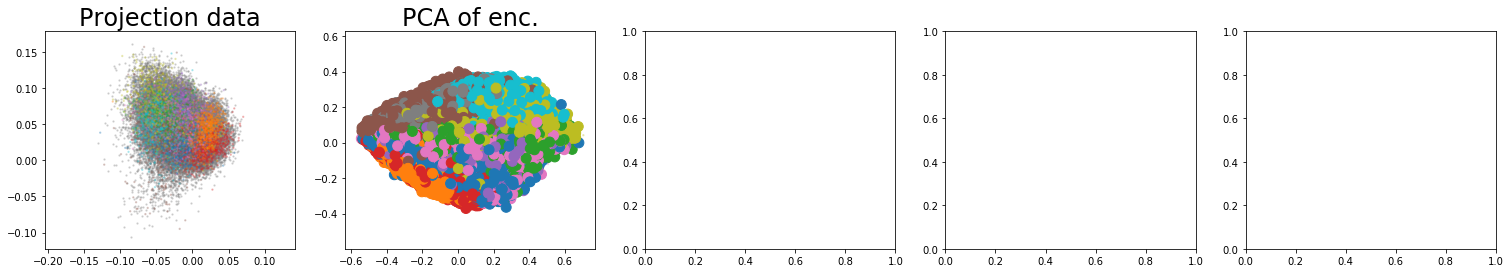

In [25]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [26]:
from tfumap.paths import MODEL_DIR

In [27]:
batch = 0; epoch = 0
N_EPOCHS = 10
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)

In [28]:
# early stopping parameters
patience = 10000 # wait this many batches without improvement before early stopping
min_delta = 0.0001 # threshold for what counts as an improvement
best_acc = 0 # the best current accuracy score
last_improvement = 0 # delta between current batch, and the last batch that was an improvement
best_saved_acc = 0 # best accuracy on valid data that has been checkpointed
best_saved_batch = 0 # batch number for last good batch
max_reinitialize_delta = .01 # minimum loss in accuracy resulting in reinitialized weights
plot_frequency = 2500 # how frequently to plot
save_frequency = 2500 # how frequently to save batches
early_stopping = False
# where to save checkpoints
cpt_path = MODEL_DIR / 'semisupervised' / dataset / datestring

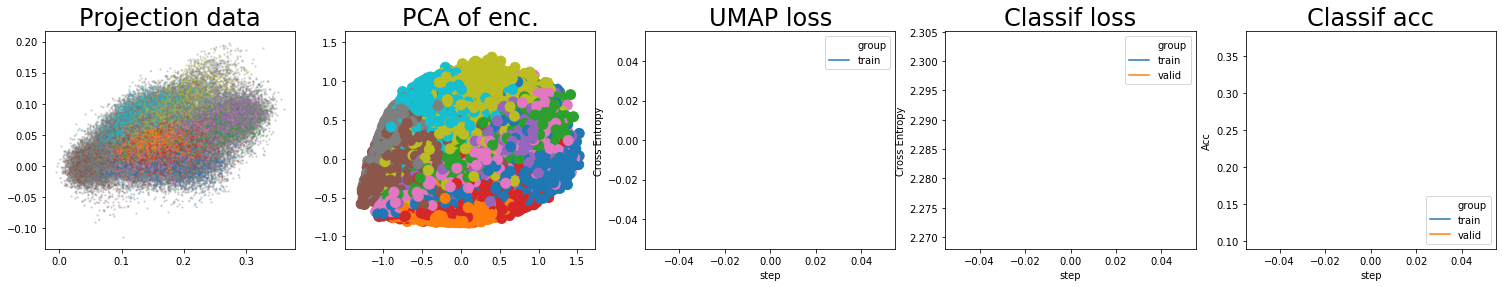

batch: 0 | train acc: 0.103 | val acc: 0.37
tf.Tensor(0.37, shape=(), dtype=float32) -0.01
saving weights


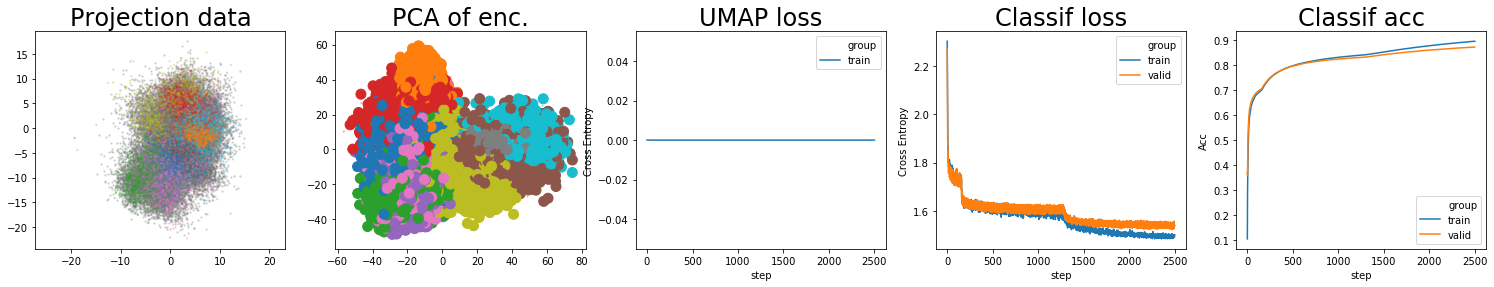

batch: 2500 | train acc: 0.8943 | val acc: 0.871
tf.Tensor(0.8710048, shape=(), dtype=float32) 0.3600000047683716
saving weights


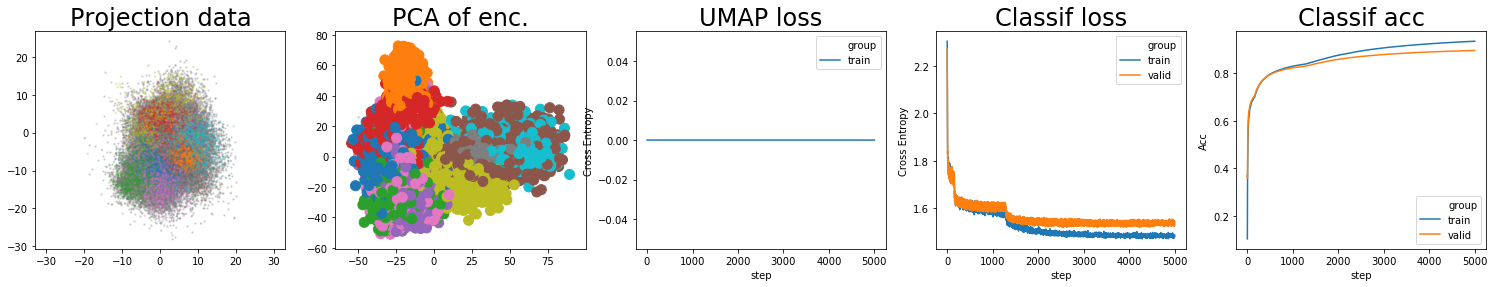

batch: 5000 | train acc: 0.9351 | val acc: 0.8964
tf.Tensor(0.8963673, shape=(), dtype=float32) 0.8610048198699951
saving weights


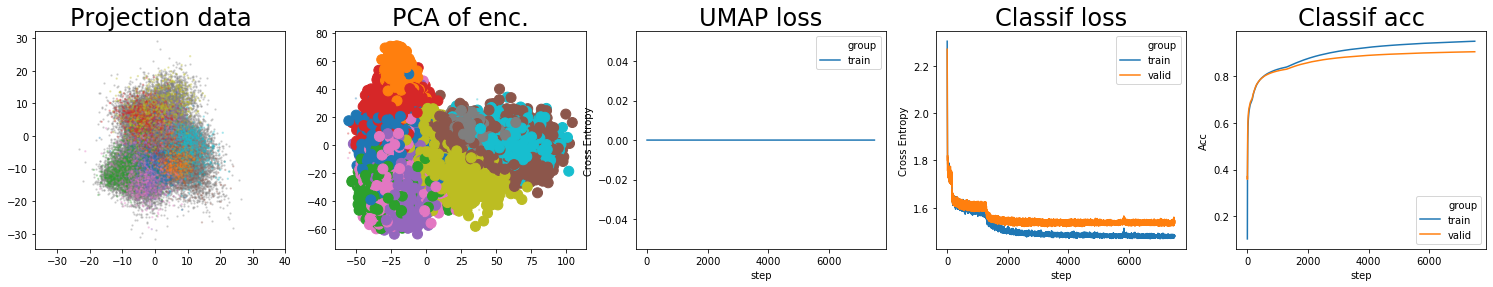

batch: 7500 | train acc: 0.9503 | val acc: 0.9053
tf.Tensor(0.9053242, shape=(), dtype=float32) 0.8863673114776611
saving weights


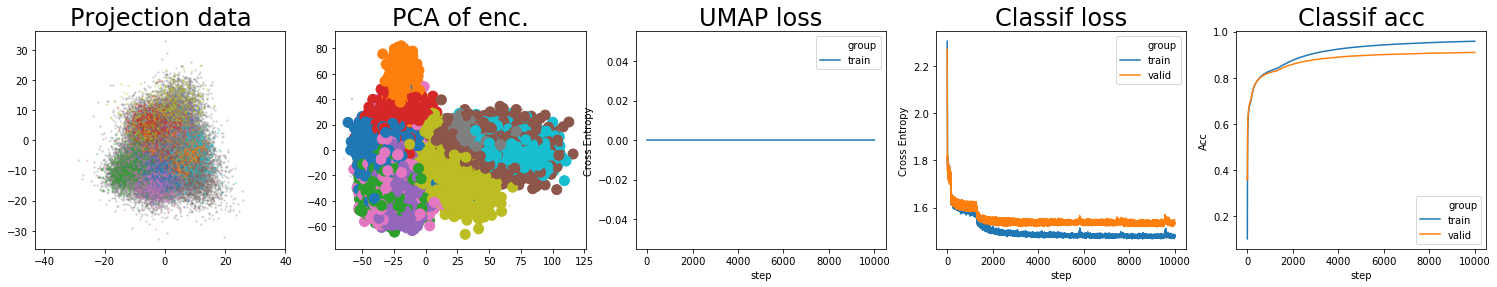

batch: 10000 | train acc: 0.9583 | val acc: 0.9101
tf.Tensor(0.9100743, shape=(), dtype=float32) 0.8953242206573486
saving weights


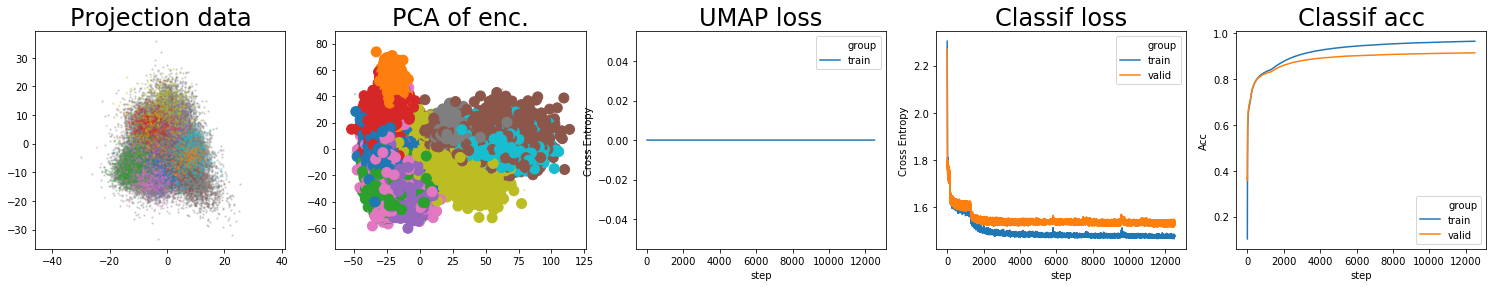

batch: 12500 | train acc: 0.9635 | val acc: 0.9131
tf.Tensor(0.91307974, shape=(), dtype=float32) 0.9000742936134338
saving weights


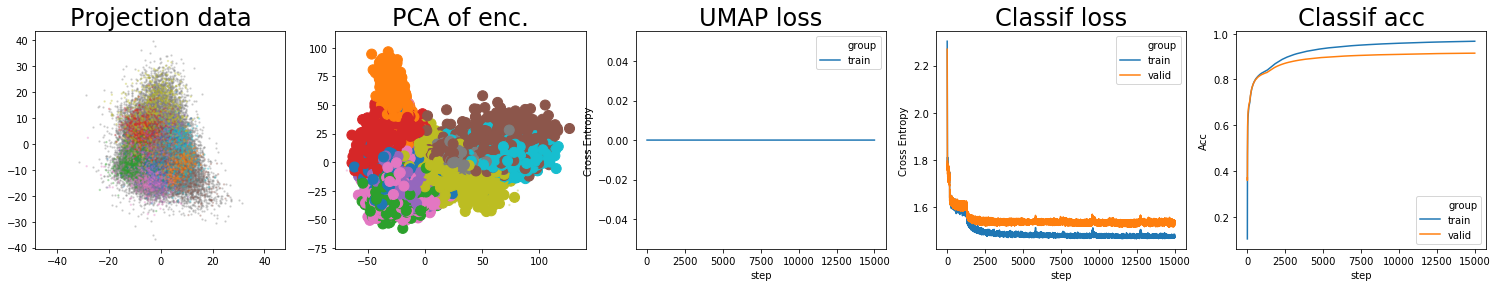

batch: 15000 | train acc: 0.9671 | val acc: 0.9149
tf.Tensor(0.91491807, shape=(), dtype=float32) 0.9030797386169434
saving weights


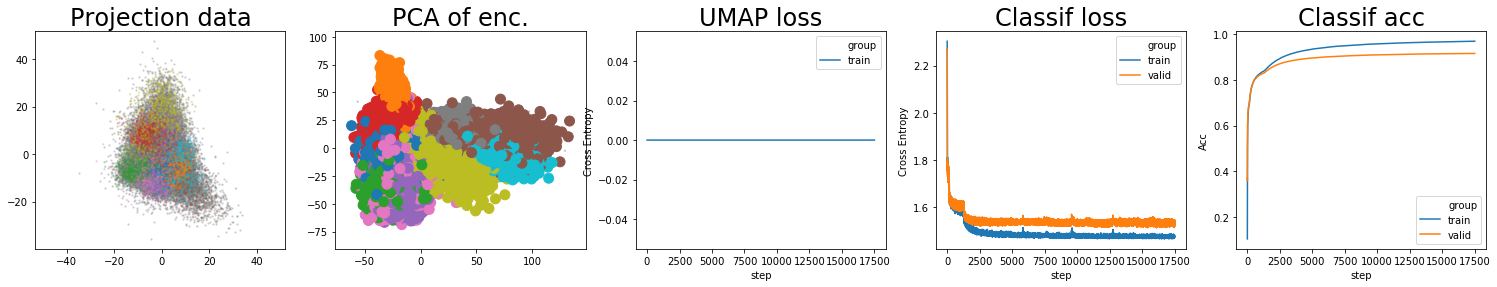

batch: 17500 | train acc: 0.9697 | val acc: 0.9162
tf.Tensor(0.9162468, shape=(), dtype=float32) 0.904918065071106
saving weights


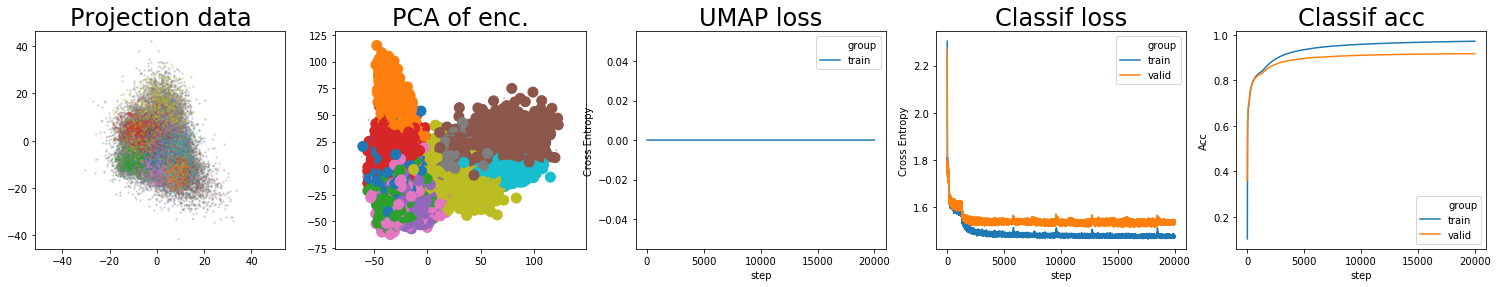

batch: 20000 | train acc: 0.9717 | val acc: 0.9173
tf.Tensor(0.91731256, shape=(), dtype=float32) 0.906246771812439
saving weights


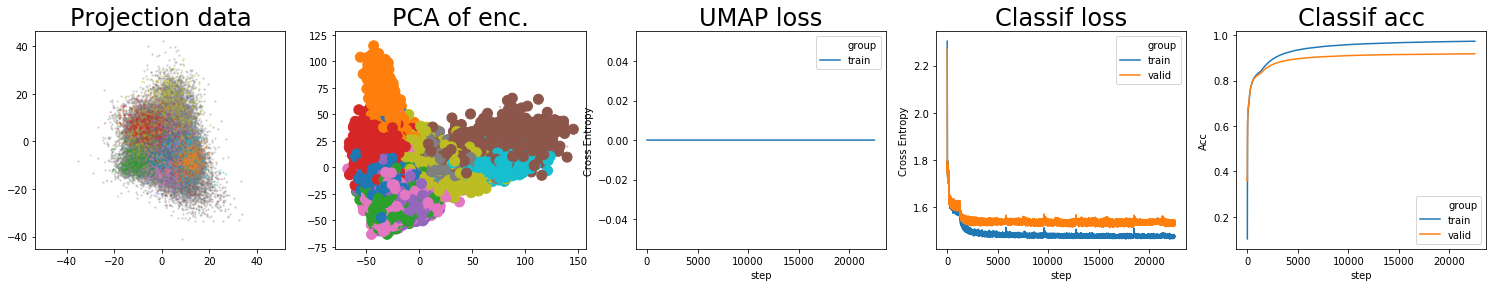

batch: 22500 | train acc: 0.9733 | val acc: 0.9182
tf.Tensor(0.9181724, shape=(), dtype=float32) 0.9073125624656677
saving weights


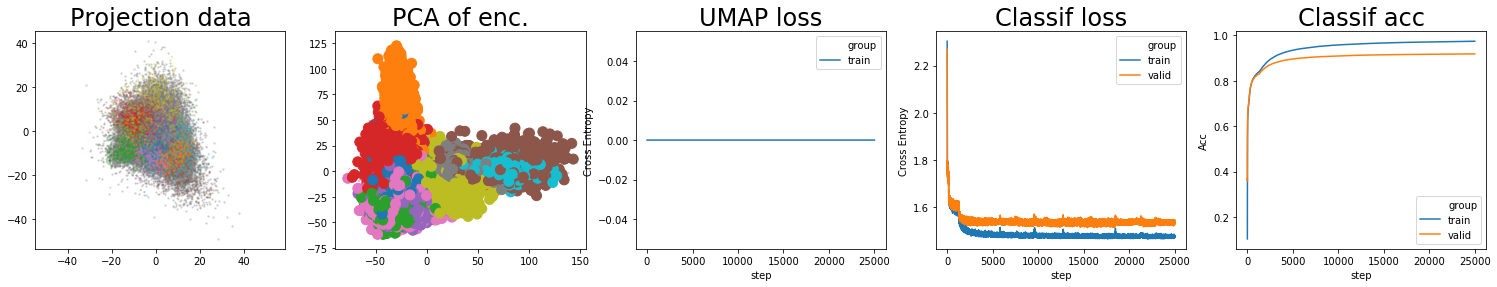

batch: 25000 | train acc: 0.9747 | val acc: 0.9188
tf.Tensor(0.9188256, shape=(), dtype=float32) 0.9081724190711975
saving weights


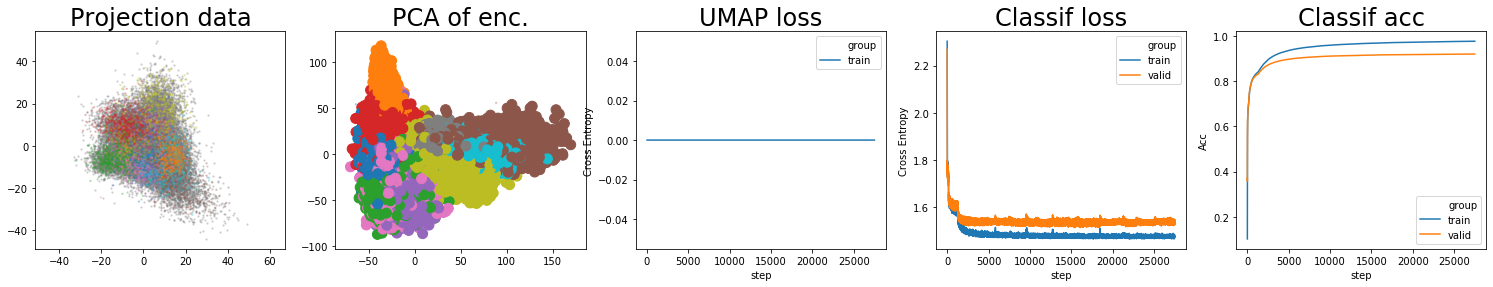

batch: 27500 | train acc: 0.9758 | val acc: 0.9192
tf.Tensor(0.91924936, shape=(), dtype=float32) 0.908825626373291
saving weights


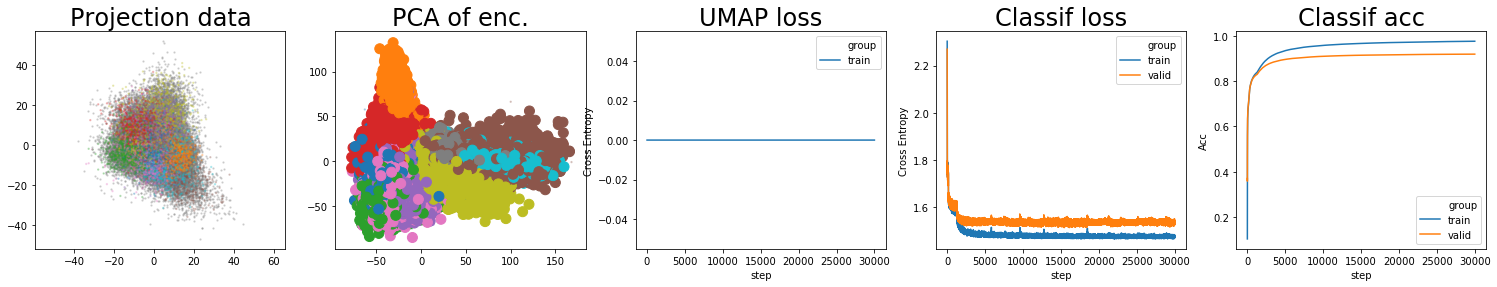

batch: 30000 | train acc: 0.9767 | val acc: 0.9197
tf.Tensor(0.91966134, shape=(), dtype=float32) 0.9092493557929993
saving weights


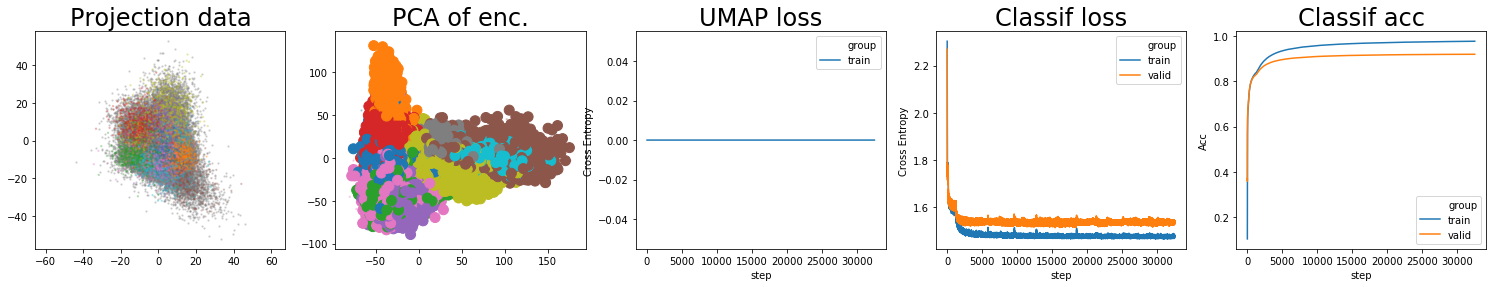

batch: 32500 | train acc: 0.9775 | val acc: 0.92
tf.Tensor(0.9199686, shape=(), dtype=float32) 0.9096613430976868
saving weights


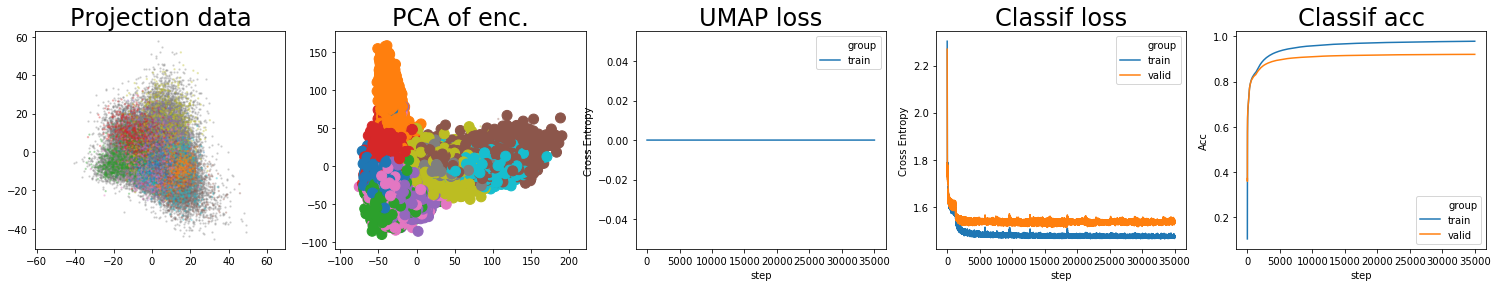

batch: 35000 | train acc: 0.9783 | val acc: 0.9202
tf.Tensor(0.9202003, shape=(), dtype=float32) 0.9099686050415039
saving weights


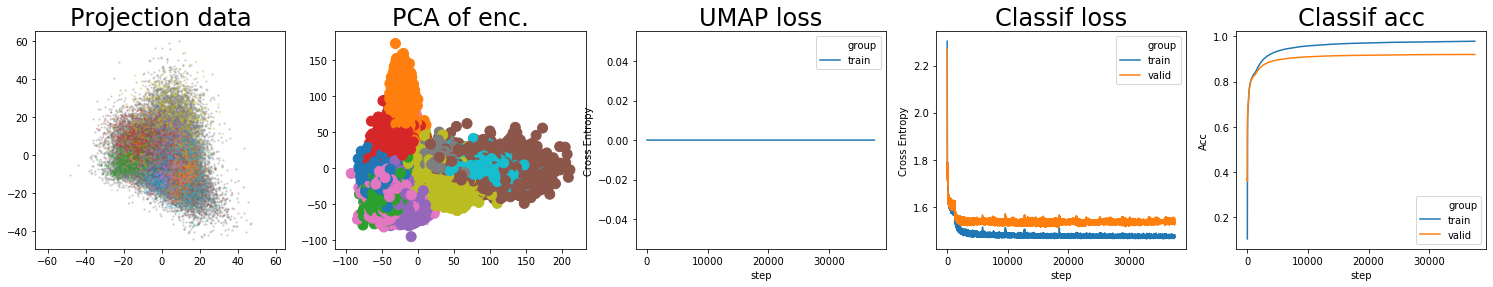

batch: 37500 | train acc: 0.9789 | val acc: 0.9204
tf.Tensor(0.9204217, shape=(), dtype=float32) 0.9102002882957458
saving weights


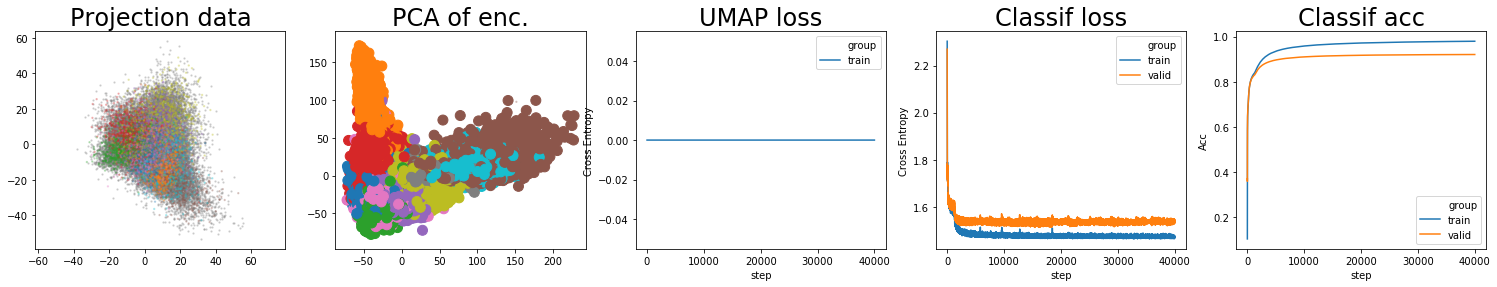

batch: 40000 | train acc: 0.9795 | val acc: 0.9207
tf.Tensor(0.92068475, shape=(), dtype=float32) 0.9104217195510864
saving weights


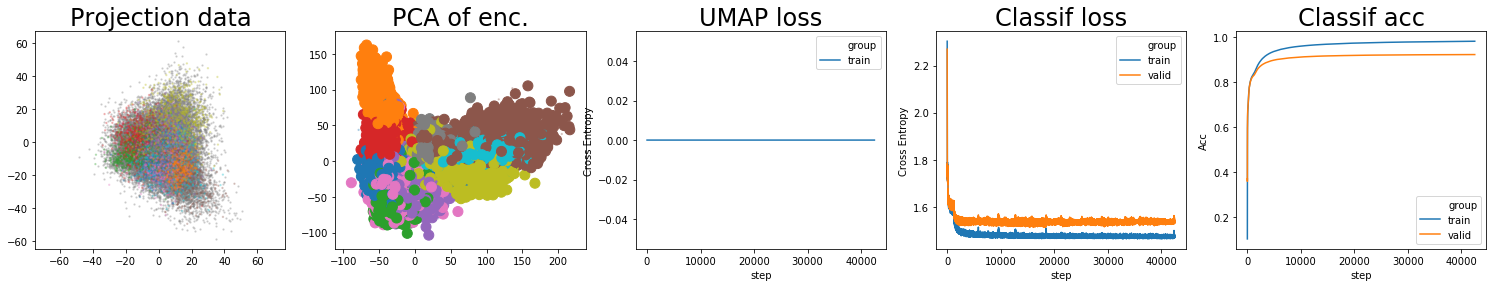

batch: 42500 | train acc: 0.98 | val acc: 0.9209
tf.Tensor(0.92091197, shape=(), dtype=float32) 0.9106847548484802
saving weights


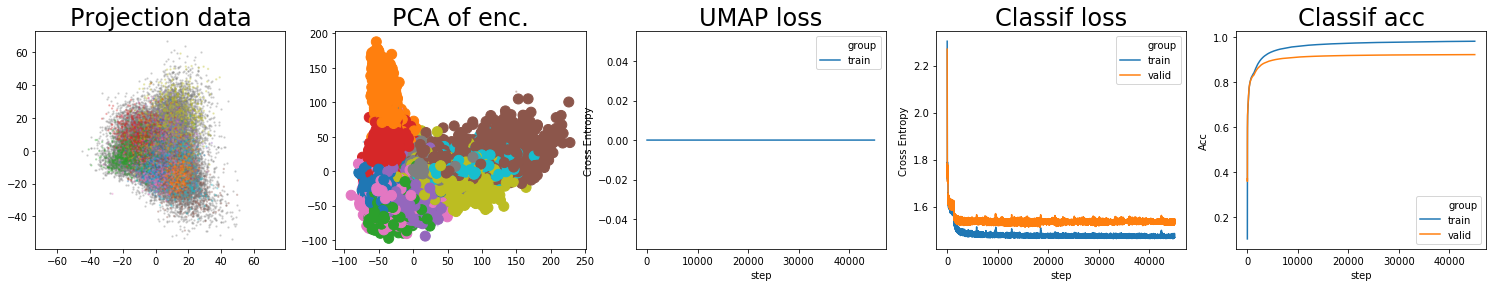

batch: 45000 | train acc: 0.9805 | val acc: 0.9212
tf.Tensor(0.92115766, shape=(), dtype=float32) 0.910911967754364
saving weights


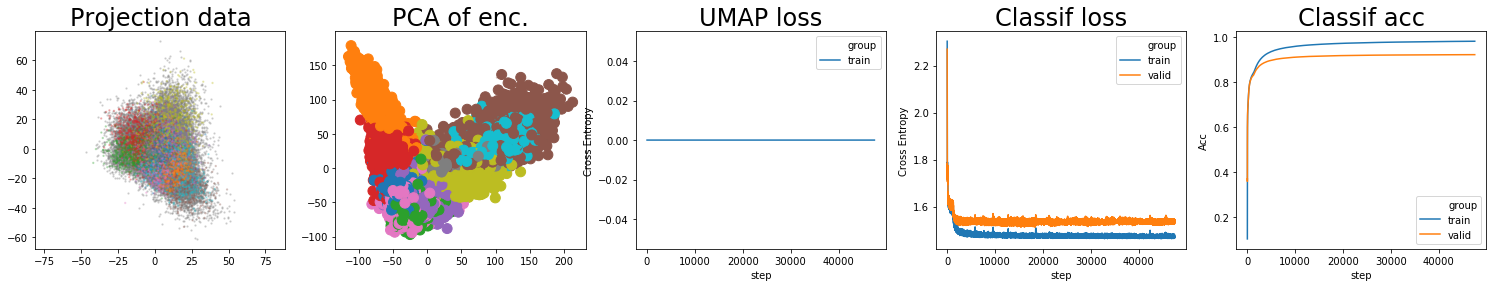

batch: 47500 | train acc: 0.9809 | val acc: 0.9213
tf.Tensor(0.9213491, shape=(), dtype=float32) 0.9111576581001282
saving weights


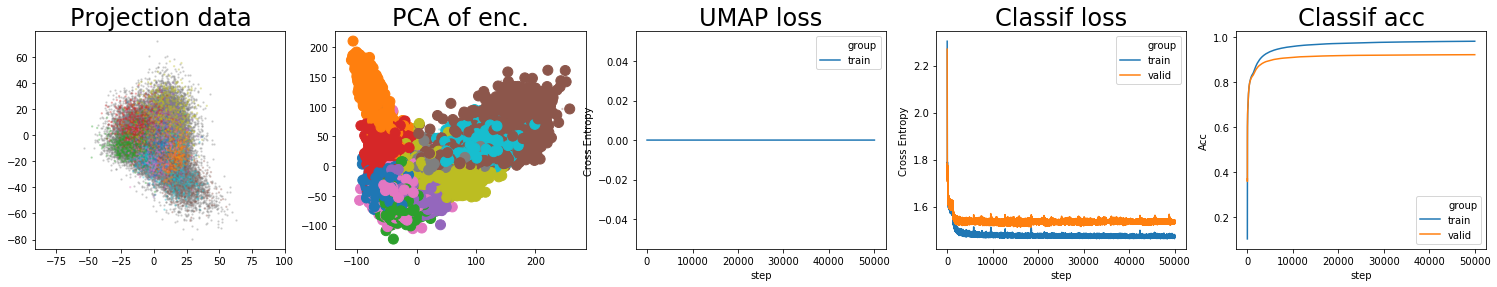

batch: 50000 | train acc: 0.9813 | val acc: 0.9216
tf.Tensor(0.92155296, shape=(), dtype=float32) 0.9113491082191467
saving weights


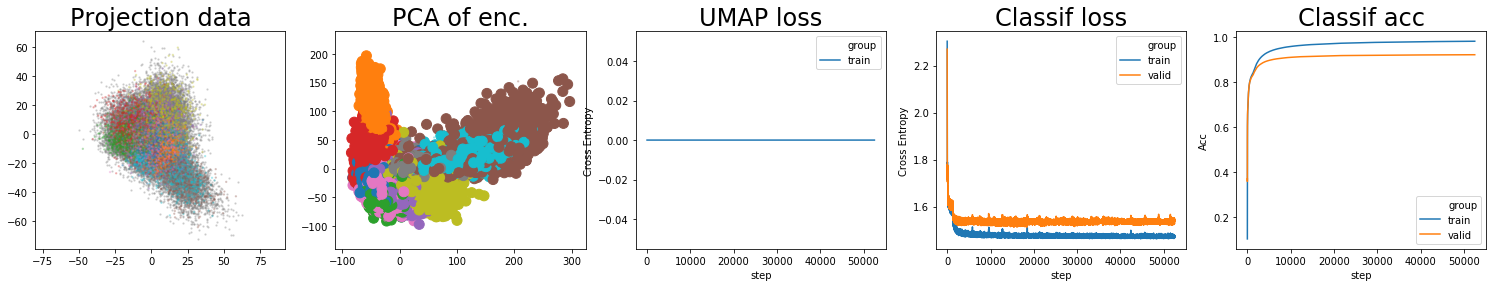

batch: 52500 | train acc: 0.9816 | val acc: 0.9217
tf.Tensor(0.9217106, shape=(), dtype=float32) 0.9115529561042786
saving weights


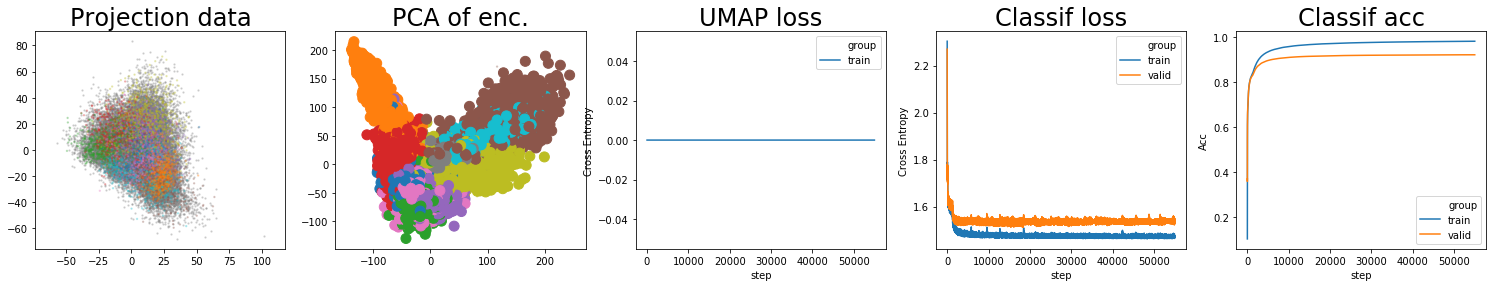

batch: 55000 | train acc: 0.982 | val acc: 0.9218
tf.Tensor(0.9217867, shape=(), dtype=float32) 0.9117106103897095
saving weights


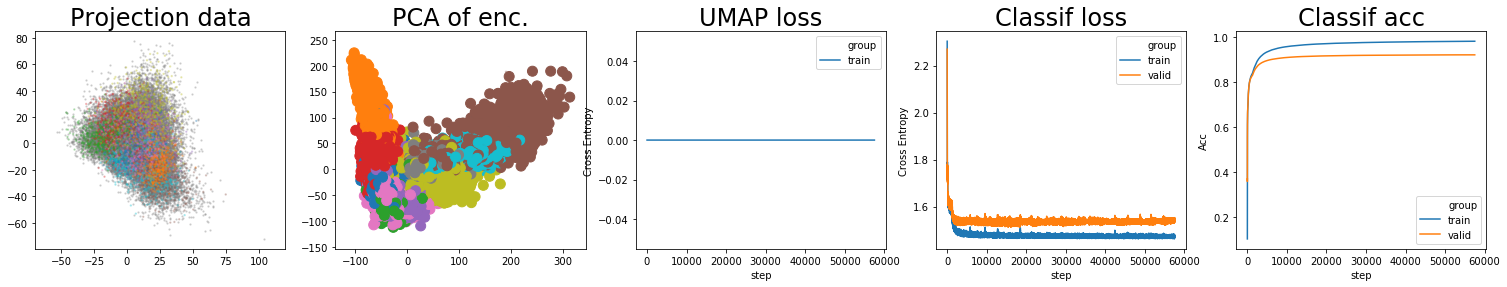

batch: 57500 | train acc: 0.9823 | val acc: 0.9218
tf.Tensor(0.92177224, shape=(), dtype=float32) 0.9117867255210876


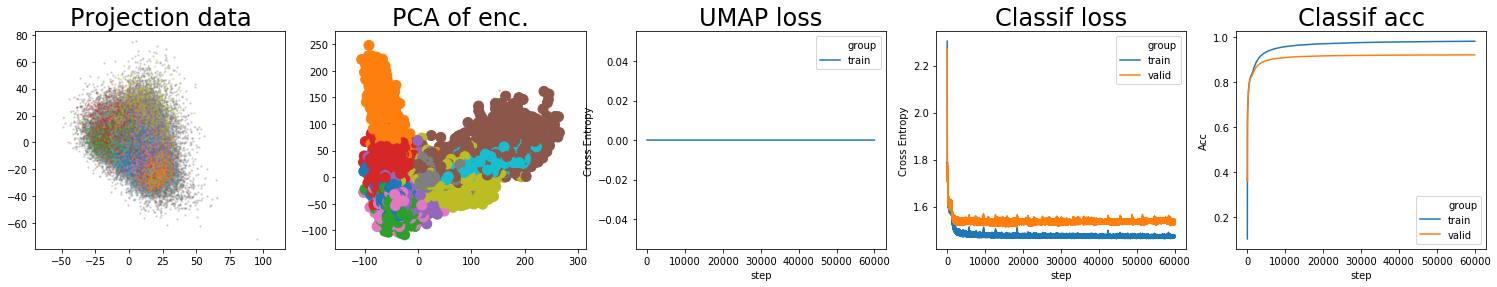

batch: 60000 | train acc: 0.9826 | val acc: 0.9218
tf.Tensor(0.92183745, shape=(), dtype=float32) 0.9117867255210876
saving weights


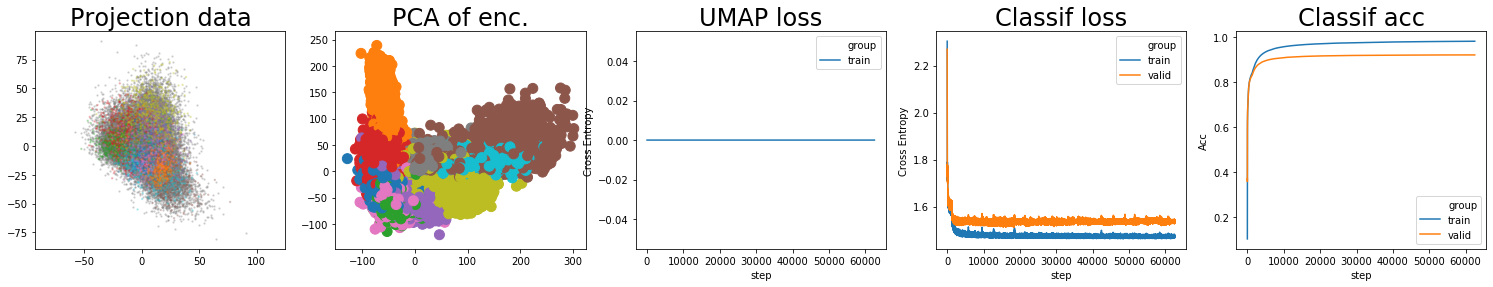

batch: 62500 | train acc: 0.9828 | val acc: 0.9219
tf.Tensor(0.9219439, shape=(), dtype=float32) 0.9118374490737915
saving weights


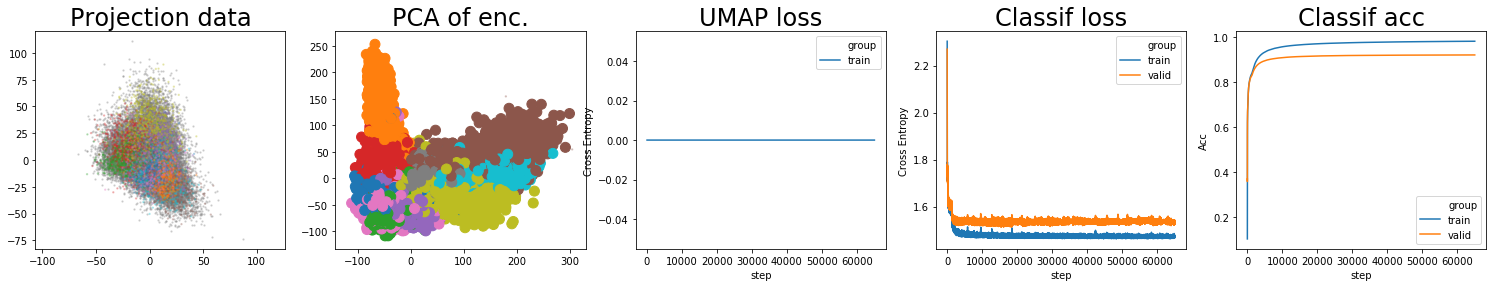

batch: 65000 | train acc: 0.9831 | val acc: 0.9221
tf.Tensor(0.9220634, shape=(), dtype=float32) 0.9119439029693603
saving weights


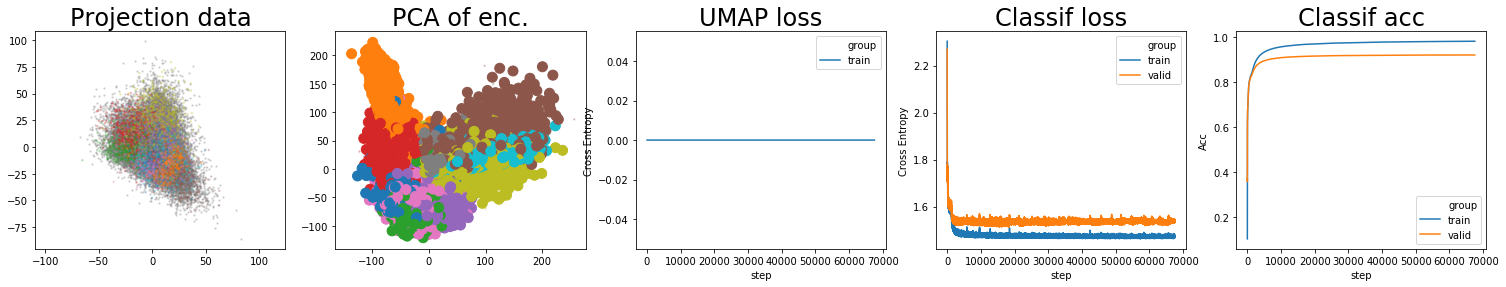

batch: 67500 | train acc: 0.9833 | val acc: 0.9221
tf.Tensor(0.92212534, shape=(), dtype=float32) 0.912063410282135
saving weights


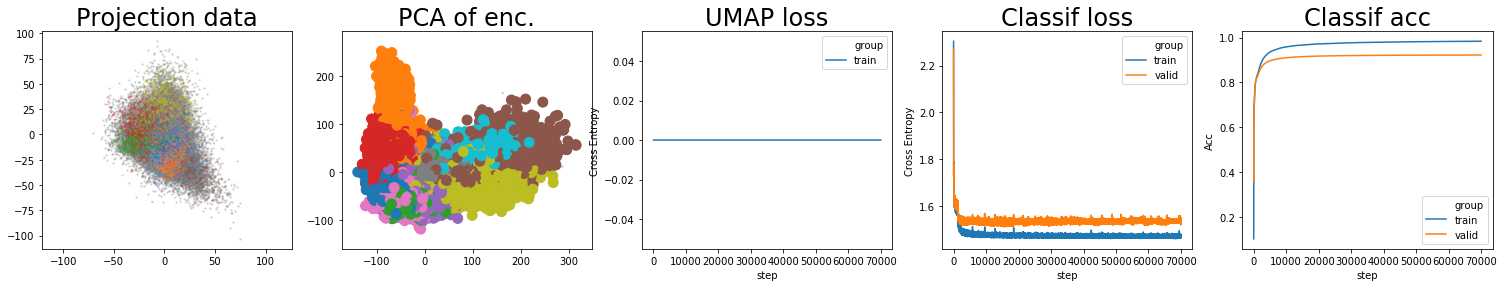

batch: 70000 | train acc: 0.9835 | val acc: 0.9221
tf.Tensor(0.9221491, shape=(), dtype=float32) 0.9121253395080566
saving weights


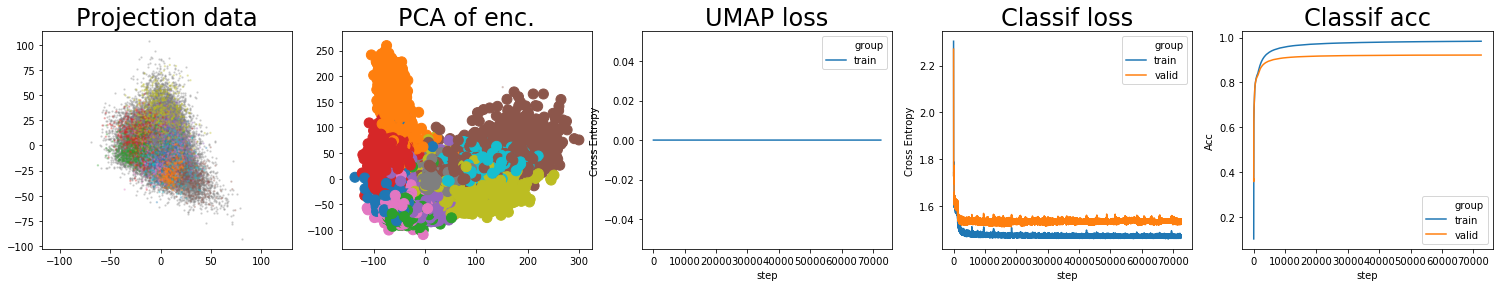

batch: 72500 | train acc: 0.9837 | val acc: 0.9222
tf.Tensor(0.9221858, shape=(), dtype=float32) 0.912149121761322
saving weights


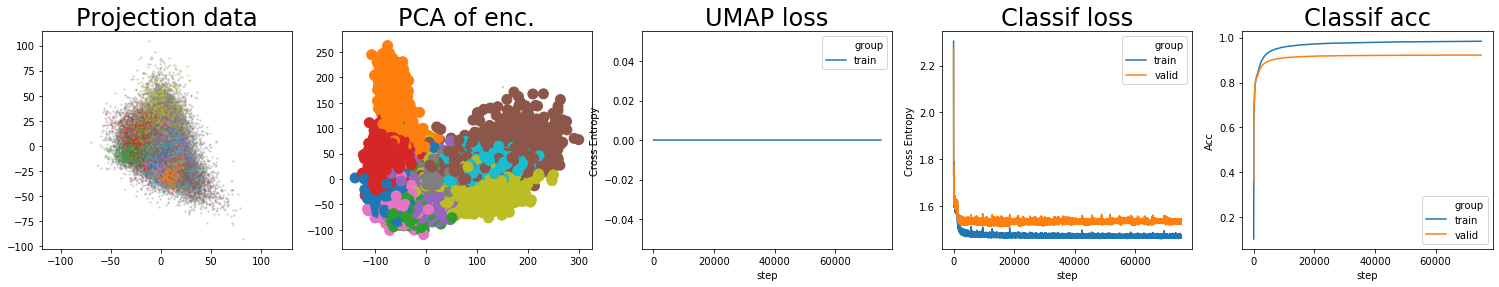

batch: 75000 | train acc: 0.9839 | val acc: 0.9222
tf.Tensor(0.9222227, shape=(), dtype=float32) 0.9121857786178589
saving weights


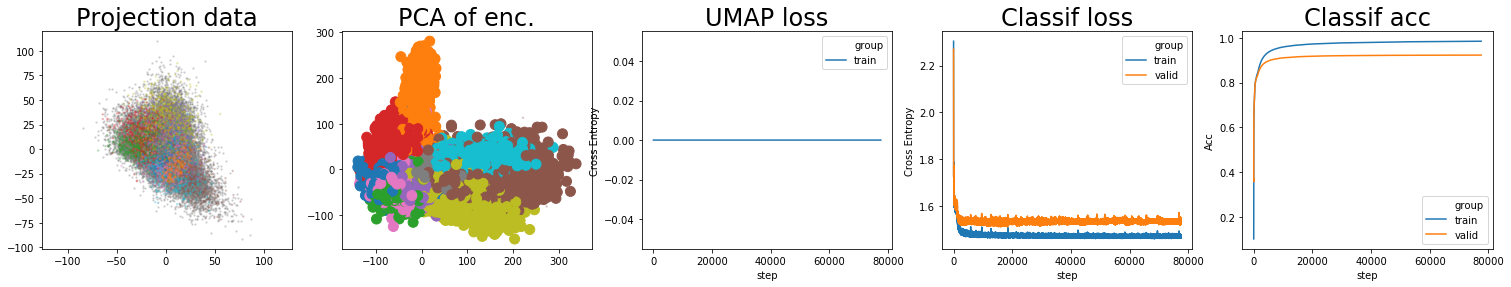

batch: 77500 | train acc: 0.9841 | val acc: 0.9222
tf.Tensor(0.9222407, shape=(), dtype=float32) 0.9122226738929748
saving weights


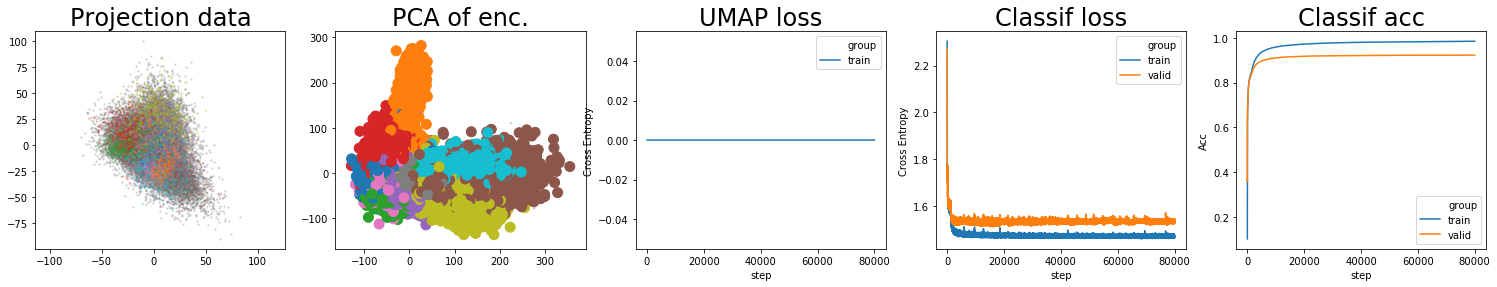

batch: 80000 | train acc: 0.9843 | val acc: 0.9223
tf.Tensor(0.9223195, shape=(), dtype=float32) 0.912240674495697
saving weights


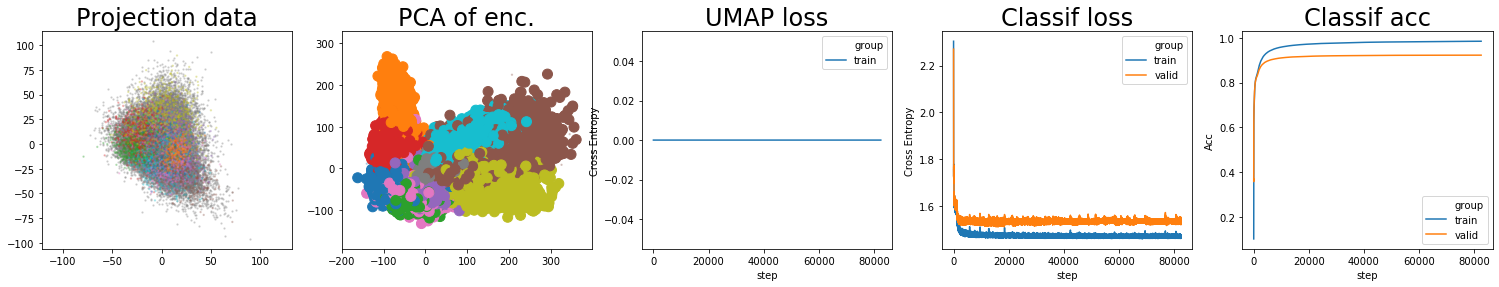

batch: 82500 | train acc: 0.9844 | val acc: 0.9224
tf.Tensor(0.9223586, shape=(), dtype=float32) 0.9123194718360901
saving weights


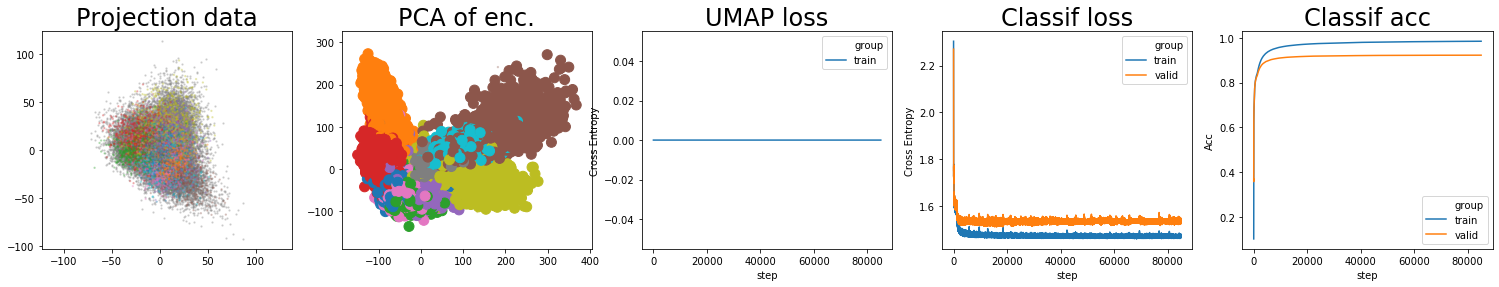

batch: 85000 | train acc: 0.9846 | val acc: 0.9224
tf.Tensor(0.9224155, shape=(), dtype=float32) 0.9123585724830627
saving weights


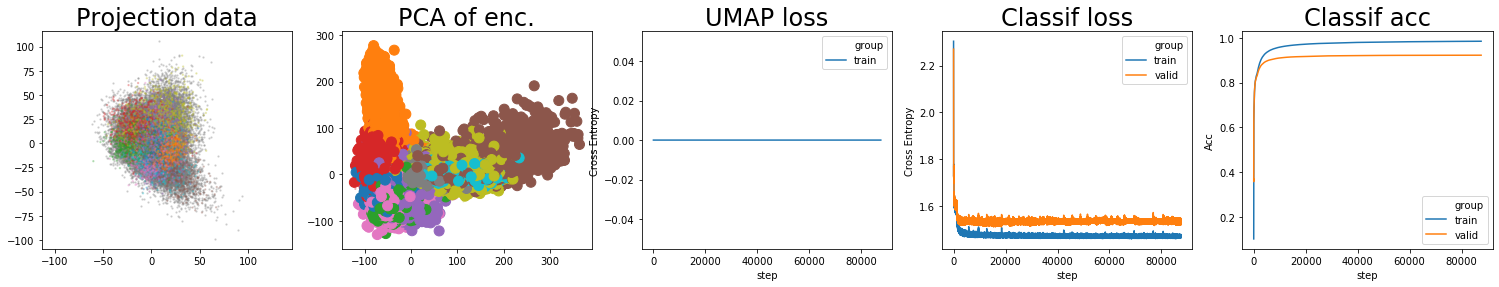

batch: 87500 | train acc: 0.9847 | val acc: 0.9224
tf.Tensor(0.92245, shape=(), dtype=float32) 0.9124154949188232
saving weights


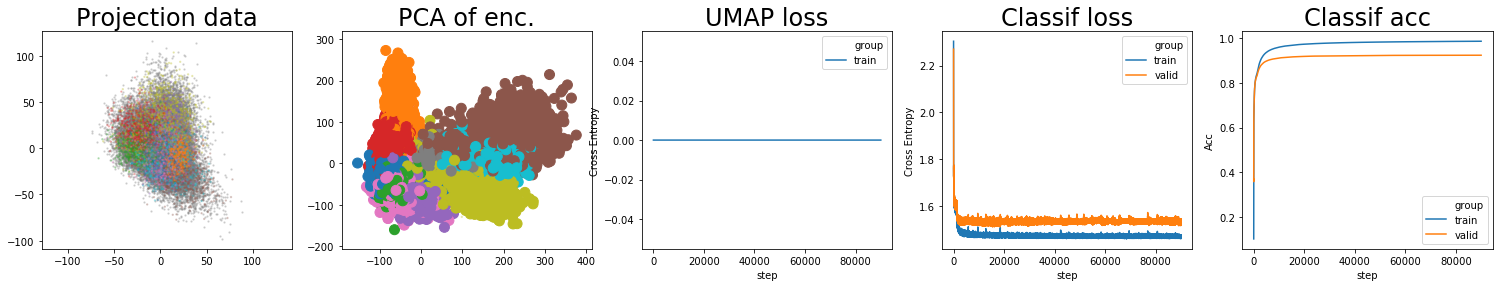

batch: 90000 | train acc: 0.9849 | val acc: 0.9225
tf.Tensor(0.92250764, shape=(), dtype=float32) 0.9124500060081482
saving weights


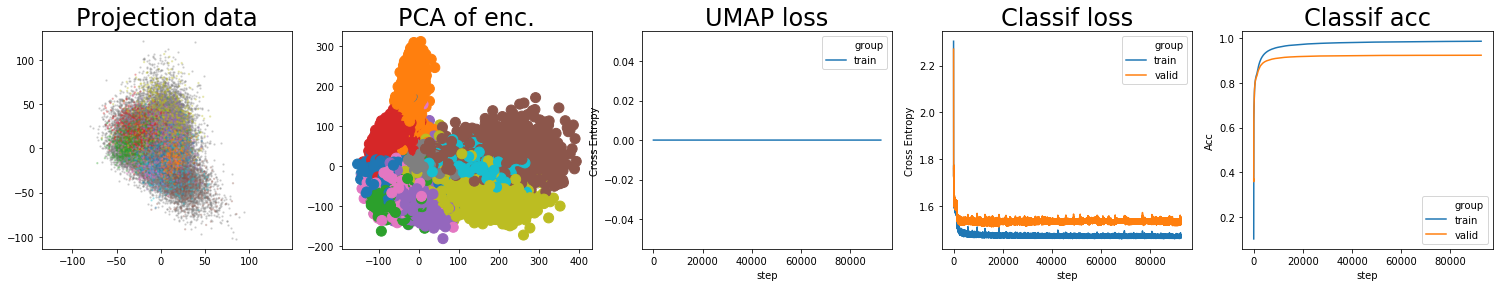

batch: 92500 | train acc: 0.985 | val acc: 0.9226
tf.Tensor(0.92258996, shape=(), dtype=float32) 0.912507643699646
saving weights


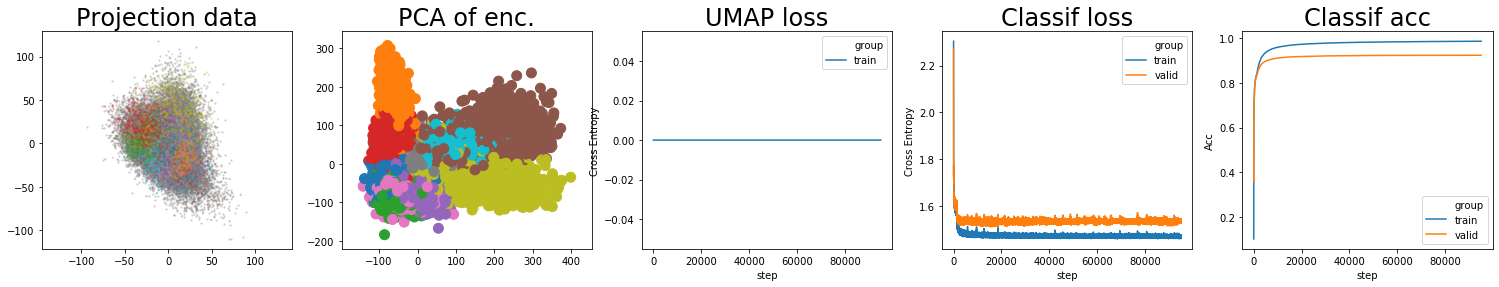

batch: 95000 | train acc: 0.9851 | val acc: 0.9226
tf.Tensor(0.92260486, shape=(), dtype=float32) 0.9125899577140808
saving weights


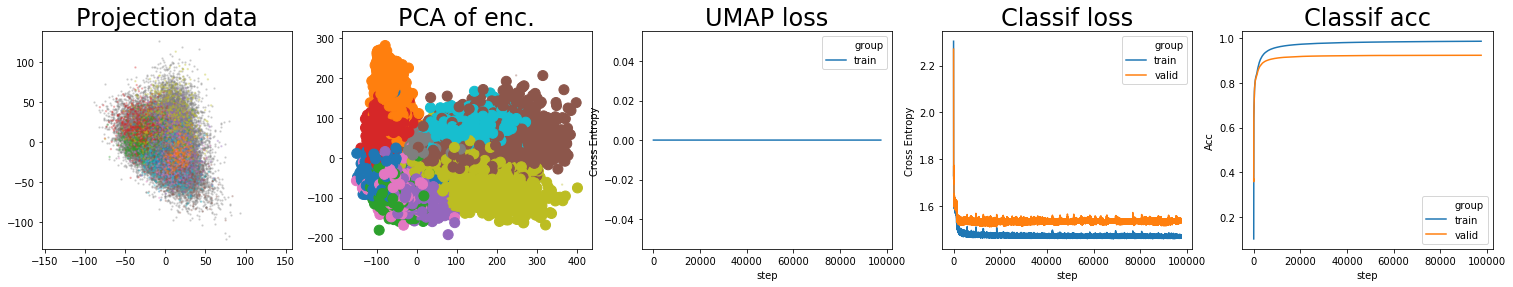

batch: 97500 | train acc: 0.9853 | val acc: 0.9226
tf.Tensor(0.92263174, shape=(), dtype=float32) 0.9126048588752746
saving weights


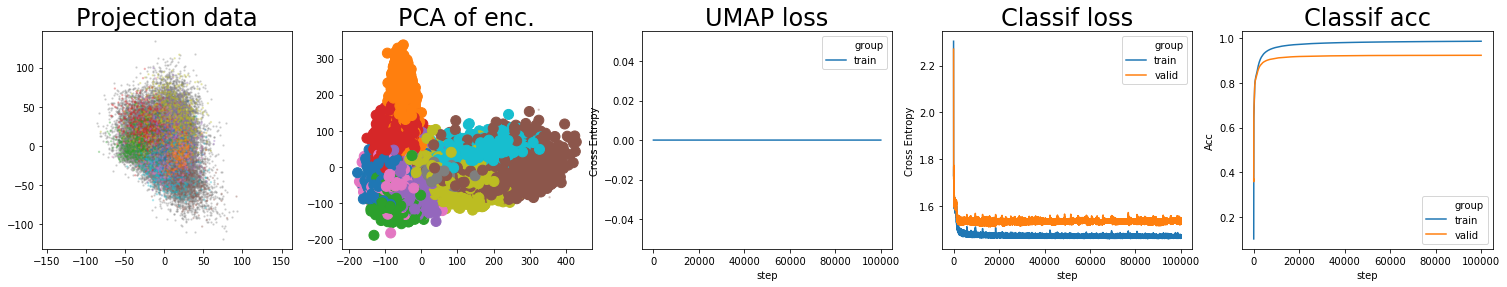

batch: 100000 | train acc: 0.9854 | val acc: 0.9227
tf.Tensor(0.9226552, shape=(), dtype=float32) 0.9126317405700684
saving weights


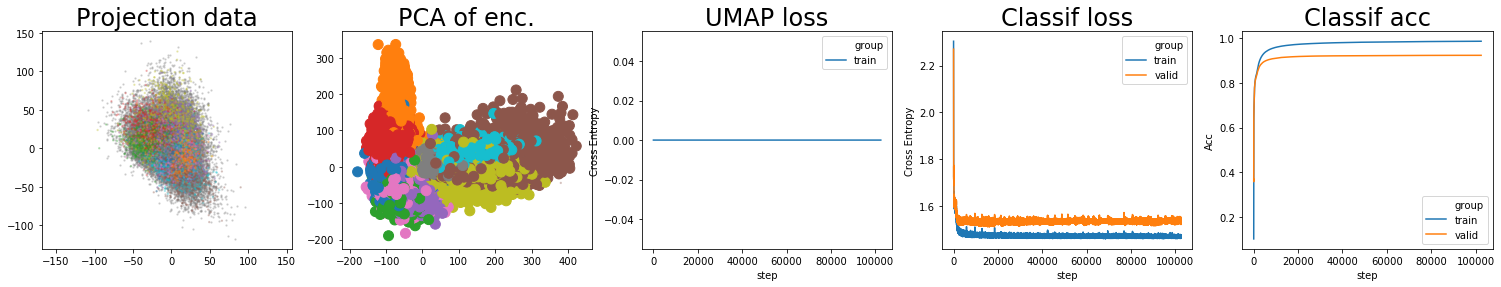

batch: 102500 | train acc: 0.9855 | val acc: 0.9227
tf.Tensor(0.92267746, shape=(), dtype=float32) 0.9126552248001099
saving weights
Early stopping


In [29]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    for (batch_to, batch_from), (X, y), (X_val, y_val) in tqdm(
        zip(edge_epoch, labeled_iter, data_valid), total=BATCHES_PER_EPOCH, leave=False
    ):

        # train
        (
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
            classifier_acc,
        ) = model.train(
            batch_to=X_train[batch_to], batch_from=X_train[batch_from], X=X, y=y
        )

        # compute validation loss
        val_loss, val_acc = compute_classifier_loss(
            X_val,
            y_val,
            model.encoder,
            model.classifier,
            model.sparse_ce,
            model.class_acc_val,
        )

        # save losses
        model.write_losses(
            tf.convert_to_tensor(batch, dtype=tf.int64),
            classifier_acc,
            classifier_loss,
            umap_loss,
            val_loss,
            val_acc,
        )
        
        # plot results
        if batch % plot_frequency == 0:
            plot_umap_classif_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )
            print(
                "batch: {} | train acc: {} | val acc: {}".format(
                    str(batch),
                    str(round(classifier_acc.numpy(), 4)),
                    str(round(val_acc.numpy(), 4)),
                )
            )
        
        #### save network
        if batch % save_frequency == 0:
            print(val_acc , (best_saved_acc - max_reinitialize_delta))
            if val_acc > best_saved_acc:
                # save weights
                print('saving weights')
                model.encoder.save_weights((cpt_path / 'encoder').as_posix())
                model.embedder.save_weights((cpt_path /'embedder').as_posix())
                model.classifier.save_weights((cpt_path / 'classifier').as_posix())
                best_saved_acc = val_acc.numpy()
                # save batch number
                best_saved_batch = copy.deepcopy(batch)
            
            elif val_acc < (best_saved_acc - max_reinitialize_delta):
                # reload weights
                print('reloading weights')
                model.encoder.load_weights((cpt_path / 'encoder').as_posix())
                model.embedder.load_weights((cpt_path / 'embedder').as_posix())
                model.classifier.load_weights((cpt_path /  'classifier').as_posix())
                
                # reset batch
                batch = copy.deepcopy(best_saved_batch)
                # reset optimizer
                for var in model.optimizer.variables():
                    var.assign(tf.zeros_like(var))
                    
                # continue on with newly updated batch (past early stopping)
                continue
        
        #### early stopping
        # if there is an imporovement, set new best score
        if val_acc > best_acc + min_delta:
            last_improvement = 0
            best_acc = val_acc
        else:
            # if model has not improved and patience has been surpassed, quit
            if last_improvement>= patience:
                print('Early stopping')
                early_stopping = True
                break
            else:
                last_improvement+=1
            
        batch += 1
    if early_stopping:
        break

In [30]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

from tfumap.semisupervised_plotting import embed_data

loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df['step'] +=1
loss_df

wall_time    step       val  group      variable
0       1.596053e+09       1  0.103000  train   classif_acc
1       1.596053e+09       2  0.246500  train   classif_acc
2       1.596053e+09       3  0.283000  train   classif_acc
3       1.596053e+09       4  0.303750  train   classif_acc
4       1.596053e+09       5  0.348400  train   classif_acc
...              ...     ...       ...    ...           ...
102958  1.596057e+09  102959  1.547224  valid  classif_loss
102959  1.596057e+09  102960  1.544963  valid  classif_loss
102960  1.596057e+09  102961  1.538706  valid  classif_loss
102961  1.596057e+09  102962  1.535023  valid  classif_loss
102962  1.596057e+09  102963  1.528042  valid  classif_loss

[514815 rows x 5 columns]

In [31]:
loss_df.to_pickle(cpt_path/'loss_df')

In [32]:
valid_acc = loss_df[
    (loss_df.group.values == "valid") & (loss_df.variable.values == "classif_acc")
].val.values

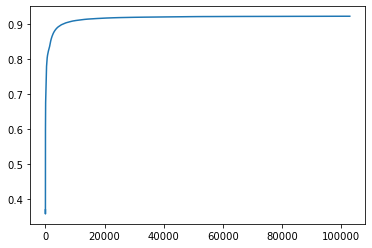

In [33]:
plt.plot(valid_acc)